In [1]:
%matplotlib inline
from helpers import *

# import 'Sequential' is a linear stack of neural network layers. Will be used to build the feed-forward CNN
from keras.models import Sequential 
# import the "core" layers from Keras (these are the most common layers)
from keras.layers import Dense, Dropout, Activation, Flatten
# import the convolutional layers that will help us efficiently train on image data
from keras.layers import Conv2D, MaxPooling2D
# these utilities will help us transform our data
from keras.utils import np_utils

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Overview
**Convolutional neural networks** (CNNs) are used to classify images. Owever our task does not consist in classifying the whole image but only its patches of 16x16 pixels. Therefore, we will need to properly choose the input of our CNN, i.e. it will have (at least) one input per patch so to classify each patch either as **road** or as **backgrund**. Moreover, each input shouldn't be just a patch of 16x16 pixels but should be a bigger "window" so to give the model a context for each patch. **The size of this window has to be refined**. A minor problem is to define the context for the patches in the border. This problem can be tackled by extending each image by mirroring its border so that also the border patches have a meaningful context. 


**TODO** try with more inputs, e.g. one input per 8x8 patch.

### - Load data

In [57]:
# Loaded a set of images
n = 100

imgs, gt_imgs = load_images(n)

imgs[0].shape, gt_imgs[0].shape

Loading 100 images


((400, 400, 3), (400, 400))

### - Define the window width

In [58]:
window_width = 72

### - Extend images by mirroring
First, as explained, we extend the input images.

In [59]:
imgs_ext = extend_images(imgs, window_width)
imgs_ext.shape

(100, 456, 456, 3)

### - For now avoid cross validation, just split the datasest in test and train. 

In [60]:
train_ratio = 0.8
train, test = split_train_test(imgs_ext, gt_imgs, train_ratio=train_ratio, seed=1)
train.imgs.shape, train.gt_imgs.shape, test.imgs.shape, test.gt_imgs.shape 

((80, 456, 456, 3), (80, 400, 400), (20, 456, 456, 3), (20, 400, 400))

### - Generate the inpus and the outputs
Now we have to transform our images into **inputs** and **outputs** that will be fed to the CNN. From each image we extract **one input per patch** that had to be classified to **road (1)** or **background (0)** (400x400/16x16=625 inputs). Lastly, we will reshape each input to fulfill the requirements of the tensorflow library. 

In [61]:
train.X, train.Y = imgs_to_inputs_outputs(train.imgs, train.gt_imgs, window_width)
test.X, test.Y = imgs_to_inputs_outputs(test.imgs, test.gt_imgs, window_width)
train.X.shape, train.Y.shape, test.X.shape, test.Y.shape

((50000, 72, 72, 3), (50000, 2), (12500, 72, 72, 3), (12500, 2))

Recap on **train** (and test) object:
- **train.imgs**: (expanded) images of the training set. **shape**=(#train images, 456, 456, 3)
- **train.gt_imgs**: respective groundtruth images. **shape**=(#train images, 400, 400)
- **train.X**: inputs extracted from train.imgs. **shape**=(#total windows, 72, 72, 3)
- **train.Y**: outputs extracted from train.gt_imgs. **shape**=(#total windows, 2)

### - Build the CNN model

In [62]:
nclasses = 2
model = Sequential()
# 32 convolution filters
# 3 rows in convolution kernel
# 3 columns in convolution kernel
# (1,28,28) is the shape of one input
# strides=(1, 1) by default (step size?)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=train.X[0].shape))
model.add(Conv2D(32, (3, 3), activation='relu'))

# MaxPooling2D is a way to reduce the number of parameters in our model by sliding 
# a 2x2 pooling filter across the previous layer and taking the max of the 4 values 
# in the 2x2 filter.
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # a method for regularizing our model in order to prevent overfitting.

# a convolutional neural network always ends with a fully connected layer followe by the ouput
# layer
# first flatten the weights of the convolution
model.add(Flatten())
# 128 = output size of the dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# 2 = output size of the output dense layer (we have 2 classes)
model.add(Dense(nclasses, activation='softmax'))

model.output_shape

(None, 2)

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### - Fit the model on the train data

In [66]:
model.fit(train.X, train.Y, batch_size=16, epochs=10, verbose=1)

Epoch 1/10
50000/50000 [==============================] - 278s 6ms/step - loss: 0.1287 - acc: 0.9479
Epoch 2/10
50000/50000 [==============================] - 278s 6ms/step - loss: 0.1166 - acc: 0.9543
Epoch 3/10
50000/50000 [==============================] - 278s 6ms/step - loss: 0.1094 - acc: 0.9563
Epoch 4/10
50000/50000 [==============================] - 278s 6ms/step - loss: 0.1040 - acc: 0.9588
Epoch 5/10
50000/50000 [==============================] - 278s 6ms/step - loss: 0.0936 - acc: 0.9645
Epoch 6/10
50000/50000 [==============================] - 278s 6ms/step - loss: 0.0914 - acc: 0.9657
Epoch 7/10
50000/50000 [==============================] - 278s 6ms/step - loss: 0.0891 - acc: 0.9665
Epoch 8/10
50000/50000 [==============================] - 276s 6ms/step - loss: 0.0842 - acc: 0.9683
Epoch 9/10
50000/50000 [==============================] - 274s 5ms/step - loss: 0.0819 - acc: 0.9691
Epoch 10/10
50000/50000 [==============================] - 277s 6ms/step - loss: 0.0824 - a

### - Evaluate the model on the test data

In [67]:
 score = model.evaluate(test.X, test.Y, verbose=1)
 score

12500/12500 [==============================] - 12s 979us/step


[0.55729067873483762, 0.864719999961853]

In [68]:
Z = model.predict_classes(test.X, verbose=1)
stats(Z, test.Y[:, 1])

12500/12500 [==============================] - 11s 889us/step

Recall = 0.744025157233
Precision = 0.729571384521
F1 = 0.736727385957


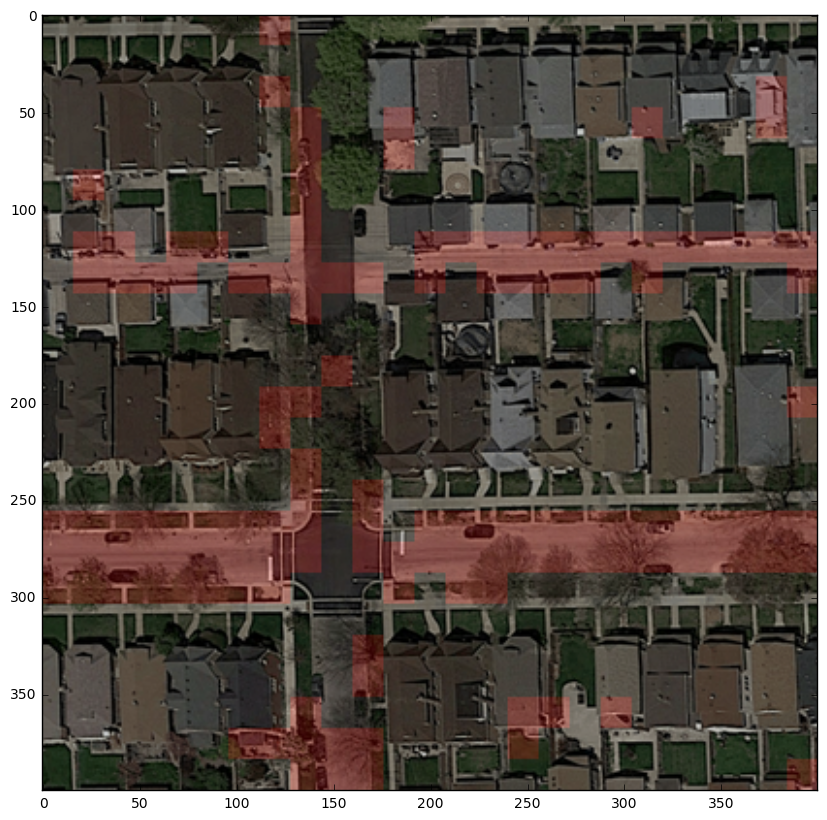

In [56]:
i = 1
display_ith_prediction(test, Z, i, window_width)

**problem**: it predicts always the same class [check here](https://stackoverflow.com/questions/41488279/neural-network-always-predicts-the-same-class)